## Feature Engineering for Clustering Spatial Analysis 

## Utrecht Province – Shared Mobility & Housing Demand Clustering
This notebook engineers spatial features from employment, housing, shared mobility and infrastructure data.  
The goal is to prepare a geospatial dataset for cluster analysis using DBSCAN or HDBSCAN to optimize shared mobility infrastructure.

### 1. Hexagonal Grid Creation
- A hexagonal grid was created to cover the Utrecht area using a 250m radius.
- The grid was filtered to include only hexagons intersecting the Utrecht province boundary.
- The grid was reprojected to match the CRS (EPSG:28992) and covers the system's location, Amersfoort, and its surroundings. 

### 2. Job Features
- Job density data for onsite, hybrid, and uncertain-location jobs was spatially joined with the hex grid.
- Counts of jobs in each category were calculated for each hexagon.
- Missing values were filled with 0, and total and weighted job counts were computed.

### 3. Housing Features
- Housing density and growth data for 2015 and 2025 were loaded and reprojected.  
- Spatial joins were performed to associate housing data with hexagons.  
- Missing values were filled with 0, and columns were renamed for clarity.  
- Additional housing data for new settlements in the entire province was incorporated.  
- Planned housing units and density scores were calculated and joined with the hex grid.  

### 4. Shared Mobility Features
- Shared mobility vehicle data (cars, bikes, scooters) was combined and deduplicated.
- Spatial joins were performed to calculate average vehicle availability per hexagon.
- Missing values were filled with 0.

### 5. Mobility Hubs
- Mobility hubs were buffered by 500m to determine coverage.
- Hexagons were flagged as covered or not based on their centroids' proximity to hubs.
- Hub types were categorized (e.g., megastation, intercity station), and a hub score was calculated.

### 6. OV-Fiets (Public Shared Bikes)
- OV-fiets hubs were buffered by 500m to determine access.
- Hexagons were flagged for OV-fiets access, and average bike availability was calculated.

### 7. Public Transport Lines
- Distances from hexagon centroids to the nearest public transport lines were calculated.
- A histogram and map were generated to visualize the distribution of distances.

### 8. Bike Networks
- Distances from hexagon centroids to direct and regional bike networks were calculated.
- The minimum distance to either network was used as the combined bike network distance.

### 9. Multimodal Access
- Hexagons were flagged for multimodal access if both bike and public transport distances were ≤ 250m.
- A multimodal access score was calculated.

### 10. Feature Engineering Summary

All engineered features were merged into a single GeoDataFrame for exploratory analysis. A total of 20 spatial indicators were created, including:

1. `hex_id`: Unique identifier for each hexagon  
2. `geometry`: Geometry of the hexagon  
3. `job_onsite`: Count of onsite jobs  
4. `job_hybrid`: Count of hybrid jobs  
5. `job_uncertain`: Count of uncertain-location jobs  
6. `job_total`: Total job count  
7. `job_weighted`: Weighted job count  
8. `housing_density_utrecht_2025`: Housing density in 2025  
9. `absolute_growth_utrecht_2025`: Absolute housing growth in 2025  
10. `planned_housing_units`: Planned housing units  
11. `planned_density_score`: Planned housing density score  
12. `avg_vehicle_availability`: Average shared mobility vehicle availability  
13. `is_covered_by_hub`: Flag indicating coverage by mobility hubs  
14. `distance_to_public_transport`: Distance to the nearest public transport line  
15. `distance_to_bike_network`: Distance to the nearest bike network  
16. `multimodal_access`: Flag for multimodal access (bike and public transport)  
17. `hub_score`: Score based on proximity to mobility hubs  
18. `ov_fiets_access`: Flag for OV-fiets access  
19. `avg_bike_availability`: Average availability of shared bikes  
20. `combined_bike_network_distance`: Minimum distance to direct or regional bike networks

These features were part of the **exploratory phase**. Only a subset was used in the **final clustering**, with some alterations to improve standardization and interpretability.

### 11. Final Selected Features for Clustering

1. `job_weighted_log`: Log-transformed weighted job count  
2. `planned_housing_units_log`: Log-transformed planned housing units  
3. `housing_density_utrecht_2025_flag`: Binary flag for 2025 housing density (high = 1, low = 0)  
4. `pt_access_score`: Composite score based on distance to public transport  
5. `hub_overall_score`: Weighted score for proximity and quality of mobility hubs  
6. `has_ovfiets_access`: Binary flag for OV-fiets access  
7. `avg_vehicle_availability`: Used as a proxy for shared mobility availability  
8. `multimodal_access`: Used for reference, but excluded from UMAP due to binary structure

### 🔧 Transformations Applied (see 3.2_feature_engineering_part2)

- **Log transformations** were used on skewed variables (`job_weighted`, `planned_housing_units`) to stabilize variance.  
- **New features** were engineered (`pt_access_score`, `hub_overall_score`) using weighted scoring systems based on multimodality and hub types.  
- Some distance-based variables were removed or replaced to reduce redundancy and improve clustering performance.

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import csv
import os
import glob
from datetime import date
from geopy.distance import geodesic
import sys

## 1.0 Generating 250m Hexagonal Grid Covering the Utrecht Area


In [ ]:
# Import required modules
import sys
from pathlib import Path

# Add parent directory to Python path to find config module
sys.path.append(str(Path().resolve().parent))

# Import config settings
from config import QGIS_DIR, PROJECT_ROOT, OUTPUT_DIR

# Import fiona for reading GeoPackage layers
import fiona

# List all layers in the GeoPackage
layers = fiona.listlayers(QGIS_DIR / "Mobility_Analysis_Utrecht_final.gpkg")
print("Layers available in the GeoPackage:")
for layer in layers:
    print(f"  - {layer}")


In [3]:
import geopandas as gpd 
from config import QGIS_DIR

# Read Netherlands boundaries
nl_boundaries = gpd.read_file(QGIS_DIR / "nl.shp", engine="pyogrio")

utrecht_province = nl_boundaries[nl_boundaries["id"] == "NLUT"].copy()

# Optional: check if it's empty
print("Utrecht geometry found:", not utrecht_province.empty)

# Reproject to match your project CRS (EPSG:28992)
utrecht_province = utrecht_province.to_crs(28992)

Utrecht geometry found: True


In [4]:
from shapely.geometry import Polygon
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx  # Add contextily for basemap


def create_hex_grid_utrecht(area_gdf, hex_diameter=250):
    # 1. Get bounds of the area with buffer to ensure full coverage
    bounds = area_gdf.geometry.total_bounds
    minx, miny, maxx, maxy = bounds
    buffer = hex_diameter
    minx -= buffer
    miny -= buffer 
    maxx += buffer
    maxy += buffer

    # 2. Calculate parameters
    dx = 3**0.5 * hex_diameter  # Horizontal distance between hexagon centers
    dy = 1.5 * hex_diameter  # Vertical distance between hexagon centers
    cols = int((maxx - minx) / dx) + 2
    rows = int((maxy - miny) / dy) + 2

    # 3. Generate hexagon centers
    hex_centers = []
    for row in range(rows):
        for col in range(cols):
            x = minx + col * dx
            y = miny + row * dy
            if row % 2 == 1:  # Offset every other row
                x += dx / 2
            hex_centers.append((x, y))

    # 4. Create hexagons starting from a flat side (not a vertex)
    def create_hexagon(center_x, center_y, size):
        angles = np.linspace(np.pi/6, 2*np.pi + np.pi/6, 7)[:-1]  # Start at pi/6 for flat side
        return Polygon([
            (center_x + size * np.cos(a), center_y + size * np.sin(a))
            for a in angles
        ])

    hexagons = [create_hexagon(x, y, hex_diameter) for x, y in hex_centers]
    hex_grid_utrecht = gpd.GeoDataFrame(geometry=hexagons, crs=area_gdf.crs)

    # 5. Filter to keep only hexagons that intersect with Utrecht
    area_union = area_gdf.geometry.union_all()
    hex_grid_utrecht = hex_grid_utrecht[hex_grid_utrecht.intersects(area_union)].reset_index(drop=True)

    return hex_grid_utrecht

# Create hex grid for Utrecht province
hex_grid_utrecht = create_hex_grid_utrecht(utrecht_province)




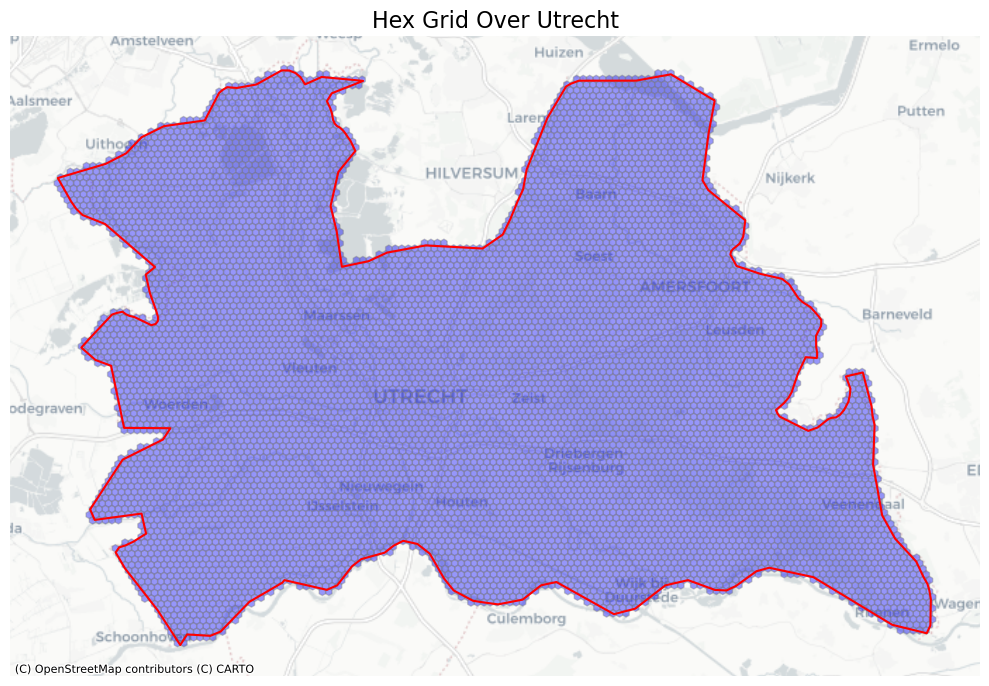

In [5]:
def plot_hex_map(
    gdf,
    boundary_gdf,
    column=None,
    cmap="YlGnBu",
    alpha=0.4,
    title="Hex Grid Over Utrecht",
    filename=None
):
    import matplotlib.pyplot as plt
    import contextily as ctx

    # Ensure both GeoDataFrames are in Web Mercator for basemap compatibility
    gdf_web = gdf.to_crs(epsg=3857)
    boundary_web = boundary_gdf.to_crs(epsg=3857)

    fig, ax = plt.subplots(figsize=(10, 10))

    if column:
        gdf_web.plot(
            column=column,
            cmap=cmap,
            legend=True,
            alpha=alpha,
            edgecolor='grey',
            linewidth=0.1,
            ax=ax,
            legend_kwds={'label': column.replace('_', ' ').title()}
        )
    else:
        gdf_web.plot(
            facecolor="blue",
            edgecolor="grey",
            alpha=alpha,
            ax=ax
        )

    boundary_web.boundary.plot(ax=ax, color='red', linewidth=1.5)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    ax.set_title(title, fontsize=16)
    ax.axis('off')
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()

# Example usage:
plot_hex_map(
    hex_grid_utrecht,
    utrecht_province,
    title="Hex Grid Over Utrecht"
)


In [6]:
# Add hex_id before exporting
hex_grid_utrecht["centroid"] = hex_grid_utrecht.geometry.centroid
hex_grid_utrecht["x"] = hex_grid_utrecht["centroid"].x.astype(int)
hex_grid_utrecht["y"] = hex_grid_utrecht["centroid"].y.astype(int)
hex_grid_utrecht["hex_id"] = hex_grid_utrecht["x"].astype(str) + "_" + hex_grid_utrecht["y"].astype(str)

# Drop centroid before saving
hex_grid_utrecht = hex_grid_utrecht.drop(columns=["centroid"])

# Export hex grid to GeoPackage
output_path = QGIS_DIR / "hex_grid_utrecht.gpkg"
hex_grid_utrecht.to_file(output_path, driver="GPKG")

# Read Netherlands boundaries
nl_boundaries = gpd.read_file(QGIS_DIR / "nl.shp", engine="pyogrio")
utrecht_province = nl_boundaries[nl_boundaries["id"] == "NLUT"].copy()

# Optional: check if it's empty
print("Utrecht geometry found:", not utrecht_province.empty)

# Reproject to match project CRS (EPSG:28992)
utrecht_province = utrecht_province.to_crs(28992)

print(f"✅ Saved GeoPackage to: {output_path}")


Utrecht geometry found: True
✅ Saved GeoPackage to: C:\Users\manoe.MC_ASUS\Documents\Utrecht_Mobility_github\Utrecht-Mobility-Project\1.0_data\1.3 - QGIS\hex_grid_utrecht.gpkg


## 2.0 Jobs_Feature


This section summarizes how job opportunity data was integrated into the hex grid by categorizing listings by mode of work:

##### Work Mode Categories
- **Onsite Jobs**: Require physical presence (e.g., retail, logistics, healthcare)
- **Hybrid Jobs**: Partially remote roles (e.g., consultants, management) 
- **Uncertain Mode**: Listings without clear workplace classification

##### Weighted Job Accessibility
A composite metric with the following weights:
- 1.0 × Onsite 
- 0.6 × Hybrid
- 0.3 × Uncertain

Each point on the job map represented one or more actual vacancies (NUMPOINTS) and was spatially joined to a hexagon using the intersects predicate.

In [7]:
# === Utrecht Job Feature Extraction and Plotting ===
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from config import QGIS_DIR, OUTPUT_DIR

# === Paths ===
gpkg_path = QGIS_DIR / "Mobility_Analysis_Utrecht_final.gpkg"
hex_grid_utrecht = QGIS_DIR / "hex_grid_utrecht.gpkg"

# === Create output directory if it doesn't exist ===
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


In [8]:
# 1. Load hex grid
hex_grid = gpd.read_file(hex_grid_utrecht)
if "id" in hex_grid.columns and "hex_id" not in hex_grid.columns:
    hex_grid = hex_grid.rename(columns={"id": "hex_id"})

# 2. Load job hex layers
onsite = gpd.read_file(gpkg_path, layer="jobs_density_onsite_workmode_2").rename(columns={"NUMPOINTS": "job_onsite"})
hybrid = gpd.read_file(gpkg_path, layer="job_density_hybrid_workmode_1").rename(columns={"NUMPOINTS": "job_hybrid"})
uncertain = gpd.read_file(gpkg_path, layer="job_density_uncertain_location_workmode_0").rename(columns={"NUMPOINTS": "job_uncertain"})

# 3. Ensure all are in the same CRS
onsite = onsite.to_crs(hex_grid.crs)
hybrid = hybrid.to_crs(hex_grid.crs)
uncertain = uncertain.to_crs(hex_grid.crs)

# 4. Spatial join: assign each job polygon to the correct hex in the master grid
onsite_joined = gpd.sjoin(onsite[["job_onsite", "geometry"]], hex_grid[["hex_id", "geometry"]], how="left", predicate="intersects")
hybrid_joined = gpd.sjoin(hybrid[["job_hybrid", "geometry"]], hex_grid[["hex_id", "geometry"]], how="left", predicate="intersects")
uncertain_joined = gpd.sjoin(uncertain[["job_uncertain", "geometry"]], hex_grid[["hex_id", "geometry"]], how="left", predicate="intersects")


In [9]:
# Aggregate each by hex_id
onsite_sum = onsite_joined.groupby("hex_id")["job_onsite"].sum().reset_index()
hybrid_sum = hybrid_joined.groupby("hex_id")["job_hybrid"].sum().reset_index()
uncertain_sum = uncertain_joined.groupby("hex_id")["job_uncertain"].sum().reset_index()

In [10]:
job_hex = (
    onsite_sum.merge(hybrid_sum, on="hex_id", how="outer")
    .merge(uncertain_sum, on="hex_id", how="outer")
).fillna(0)

job_hex["job_weighted"] = (
    job_hex["job_onsite"] * 1.0 +
    job_hex["job_hybrid"] * 0.6 +
    job_hex["job_uncertain"] * 0.3
).astype(int)


In [11]:
hex_jobs = hex_grid.merge(job_hex, on="hex_id", how="left")
for col in ["job_onsite", "job_hybrid", "job_uncertain", "job_weighted"]:
    hex_jobs[col] = hex_jobs[col].fillna(0).astype(int)


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import contextily as ctx
from pyproj import Transformer

def plot_job_features_with_stats_plus(
    gdf,
    columns,
    color_schemes,
    legend_titles,
    boundary_gdf=None,
    basemap=True,
    custom_bins=None,
    save_path=None,
    figsize=(20, 25)
):
    if not isinstance(gdf, gpd.GeoDataFrame):
        raise TypeError("gdf must be a GeoDataFrame")

    if not all(col in gdf.columns for col in columns):
        raise ValueError("Not all specified columns exist in the GeoDataFrame")

    city_labels = {
        "UTRECHT": (136784, 455860),
        "Amersfoort": (155041, 463103),
        "Nieuwegein": (133952, 448951),
        "Houten": (139963, 448940),
        "Zeist": (144446, 455827),
        "Veenendaal": (166571, 448709)
    }

    # Leader line label offsets
    label_offsets = {
        "UTRECHT": (0, 9000),
        "Zeist": (0, 9000),
        "Amersfoort": (8000, 4000),
        "Nieuwegein": (-8000, -5000),
        "Houten": (6000, -6000),
        "Veenendaal": (10000, 3000)
    }

    # Reproject to EPSG:3857 for basemap display
    if basemap:
        gdf = gdf.to_crs(epsg=3857)
        if boundary_gdf is not None:
            boundary_gdf = boundary_gdf.to_crs(epsg=3857)
        transformer = Transformer.from_crs("EPSG:28992", "EPSG:3857", always_xy=True)
        city_labels = {k: transformer.transform(*v) for k, v in city_labels.items()}

    n = len(columns)
    nrows = int(np.ceil(n / 2))
    ncols = min(n, 2)

    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(nrows * 2, ncols, height_ratios=[4, 1] * nrows)

    for idx, col in enumerate(columns):
        map_row = (idx // ncols) * 2
        map_col = idx % ncols
        ax_map = fig.add_subplot(gs[map_row, map_col])
        ax_stats = fig.add_subplot(gs[map_row + 1, map_col])

        data = gdf[col]
        data_nonzero = data[data > 0]
        pct_zeros = (data == 0).mean() * 100

        # Binning strategy
        if custom_bins and col in custom_bins:
            scheme = "userdefined"
            classification_kwds = {"bins": custom_bins[col]}
            k = len(custom_bins[col])
        else:
            scheme = "equalinterval"
            classification_kwds = {}
            k = 5

        try:
            gdf.plot(
                column=col,
                cmap=color_schemes.get(col, "viridis"),
                legend=True,
                scheme=scheme,
                k=k,
                classification_kwds=classification_kwds,
                ax=ax_map,
                alpha=0.8,
                edgecolor="grey",
                linewidth=0.1,
                legend_kwds={
                    'title': legend_titles.get(col, col),
                    'fontsize': 11,
                    'title_fontsize': 13
                }
            )
            ax_map.set_title(f"{legend_titles.get(col, col)}", fontsize=16, pad=15)

        except Exception as e:
            print(f"⚠️ Could not classify '{col}': {e}")
            gdf.plot(column=col, cmap="Greys", legend=False, ax=ax_map)
            ax_map.set_title(f"{legend_titles.get(col, col)}\n(All values equal)", fontsize=15)

        if boundary_gdf is not None:
            boundary_gdf.boundary.plot(ax=ax_map, edgecolor='black', linewidth=1)

        if basemap:
            ctx.add_basemap(ax_map, source=ctx.providers.CartoDB.Positron)

        # Plot city dots and labels with arrows
        for name, (x, y) in city_labels.items():
            dx, dy = label_offsets.get(name, (0, 5000))
            ax_map.plot(x, y, marker='o', color='black', markersize=5, zorder=3)
            ax_map.annotate(
                name,
                xy=(x, y),
                xytext=(x + dx, y + dy),
                textcoords='data',
                fontsize=14 if name == "UTRECHT" else 10,
                fontweight='bold',
                ha='center',
                va='center',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, boxstyle='round,pad=0.2'),
                arrowprops=dict(arrowstyle='-', color='black', lw=0.8)
            )

        ax_map.axis("off")

        stats_text = (
            f"Summary Statistics:\n"
            f"Total hexagons     : {len(data):,}\n"
            f"Non-zero hexagons  : {len(data_nonzero):,} ({100 - pct_zeros:.1f}%)\n"
            f"Mean               : {data.mean():.1f}\n"
            f"Median             : {data.median():.1f}\n"
            f"Max                : {data.max():.1f}"
        )
        ax_stats.axis("off")
        ax_stats.text(
            0.05, 0.95, stats_text,
            transform=ax_stats.transAxes,
            verticalalignment='top',
            fontfamily='monospace',
            fontsize=16
        )

    plt.tight_layout()
    if save_path:
        try:
            fig.savefig(save_path, dpi=300, bbox_inches="tight")
            print("✅ Figure saved successfully.")
        except Exception as e:
            print(f"⚠️ Could not save figure: {e}")

    plt.show()

In [13]:
# Create job_maps directory if it doesn't exist
job_maps_dir = OUTPUT_DIR / "job_maps"
job_maps_dir.mkdir(exist_ok=True)
job_columns=["job_onsite", "job_hybrid", "job_uncertain", "job_weighted"]
# Export combined map
plot_job_features_with_stats_plus(
    gdf=hex_jobs,
    columns=job_columns,
    color_schemes={
        "job_onsite": "BuGn",
        "job_hybrid": "BuPu", 
        "job_uncertain": "YlOrBr",
        "job_weighted": "magma"
    },
    legend_titles={
        "job_onsite": "Onsite Jobs",
        "job_hybrid": "Hybrid Jobs",
        "job_uncertain": "Uncertain Jobs",
        "job_weighted": "Weighted Jobs"
    },
    custom_bins={
        "job_onsite": [0, 10, 25, 50, 100, 200, 500, 1000],
        "job_hybrid": [0, 10, 25, 50, 100, 200, 500, 1000],
        "job_uncertain": [0, 10, 25, 50, 100, 200, 500, 1000],
        "job_weighted": [0, 10, 25, 50, 100, 200, 500, 1000]
    },
    save_path=job_maps_dir / "job_features_graduated.png"
)

✅ Figure saved successfully.


In [ ]:
# Export individual maps using plot_job_features_with_stats_plus
export_individual_maps = False  # Set to False to skip exporting

if export_individual_maps:
    for column in job_columns:
        save_path = job_maps_dir / f"{column}_graduated.png"
        plot_job_features_with_stats_plus(
            gdf=hex_jobs,
            columns=[column],
            color_schemes={
                column: "BuGn" if column == "job_onsite" else
                       "BuPu" if column == "job_hybrid" else
                       "YlOrBr" if column == "job_uncertain" else
                       "magma"
            },
            legend_titles={
                column: "Onsite Jobs" if column == "job_onsite" else
                       "Hybrid Jobs" if column == "job_hybrid" else
                       "Uncertain Jobs" if column == "job_uncertain" else
                       "Weighted Jobs"
            },
            custom_bins={
                column: [0, 10, 25, 50, 100, 200, 500, 1000]
            },
            save_path=save_path
        )

    

## 3.0 Housing features



This section summarizes the integration of multiple housing-related datasets into the hex grid:

- **Housing Density (2025)**: Based on projected residential density at the neighborhood level
- **Absolute Growth (2015–2025)**: Net change in housing stock over the past decade
- **Planned Dwellings (Province)**: Total units planned per location, from the Province's housing plan
- **Planned Density Score**: A synthetic score that weights multifamily housing higher to reflect intensity

> ℹ️ Most hexagons have no values in these columns — especially for 2025 and growth — because those layers are geographically concentrated in the urban core or around major development areas.

In [ ]:
import geopandas as gpd
import pandas as pd
from config import QGIS_DIR

# === Load main hex grid ===
hex_grid_utrecht = gpd.read_file(QGIS_DIR / "hex_grid_utrecht.gpkg")

# === Load buurt polygons ===
gpkg_path = QGIS_DIR / "Mobility_Analysis_Utrecht_final.gpkg"
buurten_gdf = gpd.read_file(gpkg_path, layer="buurten")

# === Load city-level housing layers ===
gdf_density = gpd.read_file(QGIS_DIR / "housing_heatmap_2025.gpkg").rename(
    columns={"2025": "housing_density_utrecht_2025"}
)

gdf_growth = gpd.read_file(QGIS_DIR / "housing_heatmap_absolute_growth.gpkg").rename(
    columns={"Absolute_G": "absolute_growth_utrecht_2025"}
)

# === Load province-level housing plans ===
housing_plans = gpd.read_file(QGIS_DIR / "housing_province.gpkg")

# 4. Reproject all to EPSG:28992 just in case
for df in [buurten_gdf, gdf_density, gdf_growth, housing_plans, hex_grid_utrecht]:
    if df.crs.to_epsg() != 28992:
        df.to_crs(epsg=28992, inplace=True)

# Filter and engineer features
housing_plans = housing_plans[housing_plans["TOTAAL"] > 0].copy()
housing_plans["planned_housing_units"] = housing_plans[["MEERGEZINS", "EENGEZINS"]].sum(axis=1)
housing_plans["planned_density_score"] = (
    housing_plans["MEERGEZINS"] * 2 + housing_plans["EENGEZINS"]
)
housing_plans = housing_plans[["geometry", "planned_housing_units", "planned_density_score"]]

# ✅ Print confirmation
print("✅ Housing layers loaded and processed")
print(f"- Density points: {len(gdf_density)}")
print(f"- Growth points: {len(gdf_growth)}")
print(f"- Plans polygons: {len(housing_plans)}")


In [16]:
# === 1. Assign each centroid to a neighborhood ===


# Density (mean per buurt)
buurten_density = gpd.sjoin(buurten_gdf, gdf_density[["housing_density_utrecht_2025", "geometry"]], how="left", predicate="contains")
# Growth (sum per buurt)
buurten_growth = gpd.sjoin(buurten_gdf, gdf_growth[["absolute_growth_utrecht_2025", "geometry"]], how="left", predicate="contains")
# Plans (sum per buurt)
buurten_plans = gpd.sjoin(buurten_gdf, housing_plans[["planned_housing_units", "planned_density_score", "geometry"]], how="left", predicate="contains")

# === 2. Join hexes to buurten — every hex inherits the neighborhood's value ===
density_hex = gpd.sjoin(hex_grid_utrecht, buurten_density[["housing_density_utrecht_2025", "geometry"]], how="left", predicate="intersects")
growth_hex = gpd.sjoin(hex_grid_utrecht, buurten_growth[["absolute_growth_utrecht_2025", "geometry"]], how="left", predicate="intersects")
plans_hex = gpd.sjoin(hex_grid_utrecht, buurten_plans[["planned_housing_units", "planned_density_score", "geometry"]], how="left", predicate="intersects")

# === 3. Combine values per hex_id (one-to-one match) ===
density_grouped = density_hex.groupby("hex_id")["housing_density_utrecht_2025"].mean().reset_index()
growth_grouped = growth_hex.groupby("hex_id")["absolute_growth_utrecht_2025"].sum().reset_index()
plans_grouped = plans_hex.groupby("hex_id")[["planned_housing_units", "planned_density_score"]].sum().reset_index()

# === 4. Merge into one housing DataFrame ===
housing_hex = density_grouped.merge(growth_grouped, on="hex_id", how="outer")
housing_hex = housing_hex.merge(plans_grouped, on="hex_id", how="outer").fillna(0)

# === 5. Merge with the full hex grid to retain geometry ===
hex_housing = hex_grid_utrecht.merge(housing_hex, on="hex_id", how="left")

# === 6. Fill missing values in key columns with zero ===
for col in ["housing_density_utrecht_2025", "absolute_growth_utrecht_2025", "planned_housing_units", "planned_density_score"]:
    hex_housing[col] = hex_housing[col].fillna(0)

# ✅ Final check
print("✅ Centroid values assigned via buurten → hexes")
print(hex_housing[[
    "housing_density_utrecht_2025",
    "absolute_growth_utrecht_2025",
    "planned_housing_units",
    "planned_density_score"
]].describe())


✅ Centroid values assigned via buurten → hexes
       housing_density_utrecht_2025  absolute_growth_utrecht_2025  \
count                   8940.000000                   8940.000000   
mean                      88.797237                     29.442170   
std                      400.766494                    220.783963   
min                        0.000000                  -1200.000000   
25%                        0.000000                      0.000000   
50%                        0.000000                      0.000000   
75%                        0.000000                      0.000000   
max                     4286.000000                   5305.000000   

       planned_housing_units  planned_density_score  
count            8940.000000            8940.000000  
mean              103.474720              70.711633  
std               511.406836             460.531631  
min                 0.000000               0.000000  
25%                 0.000000               0.000000  
50%    

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from mapclassify import Quantiles, NaturalBreaks
import contextily as ctx

# --- Load Utrecht city boundary for plotting (only once, outside the function) ---
try:
    # Explicitly set the layer to 'housing_geometry_dark_copy' (default)
    utrecht_city_boundary = gpd.read_file(QGIS_DIR / "utrecht_city_boundaries.gpkg", layer="housing_geometry_dark_copy")
    # Reproject to EPSG:28992 for plotting
    utrecht_city_boundary = utrecht_city_boundary.to_crs(epsg=28992)
    # Set a light color for the boundary for later plotting
    # NOTE: linewidth set to 0.2 for a VERY THIN hairline
    utrecht_city_boundary_plot_kwargs = dict(edgecolor="#cccccc", linewidth=0.2, facecolor="none", zorder=10)
except Exception as e:
    print(f"⚠️ Could not load Utrecht city boundary: {e}")
    utrecht_city_boundary = None
    utrecht_city_boundary_plot_kwargs = {}

def plot_distribution_with_stats(
    gdf,
    columns,
    color_schemes,
    legend_titles,
    buurten=None,
    city_layers=None,
    utrecht_outline=None,
    save_path=None,
    use_log_scale=False,
    custom_bins=None,
    figsize=(20, 25),
    province_linewidth=0.5
):
    # EPSG:28992 coordinates
    city_labels = {
        "UTRECHT": (136784, 455860),
        "Amersfoort": (155041, 463103),
        "Nieuwegein": (133952, 448951),
        "Houten": (139963, 448940),
        "Zeist": (144446, 455827),
        "Veenendaal": (166571, 448709)
    }

    # Leader line label offsets
    label_offsets = {
        "UTRECHT": (0, 9000),
        "Zeist": (0, 9000),
        "Amersfoort": (8000, 4000),
        "Nieuwegein": (-8000, -5000),
        "Houten": (6000, -6000),
        "Veenendaal": (10000, 3000)
    }

    figsize = (figsize[0] * 1.5, figsize[1] * 1.5)
    n = len(columns)
    nrows = int(np.ceil(n / 2))
    ncols = min(n, 2)

    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(nrows * 2, ncols, height_ratios=[4, 1] * nrows)

    # Prepare buurten boundaries for plotting if provided
    buurten_plot = None
    if buurten is not None:
        buurten_plot = buurten.to_crs(epsg=28992) if buurten.crs and buurten.crs.to_epsg() != 28992 else buurten

    for idx, col in enumerate(columns):
        map_row = (idx // ncols) * 2
        map_col = idx % ncols
        ax_map = fig.add_subplot(gs[map_row, map_col])
        ax_stats = fig.add_subplot(gs[map_row + 1, map_col])

        # Reproject data
        gdf_plot = gdf.to_crs(epsg=28992) if gdf.crs and gdf.crs.to_epsg() != 28992 else gdf
        utrecht_outline_plot = utrecht_outline.to_crs(epsg=28992) if utrecht_outline is not None and utrecht_outline.crs.to_epsg() != 28992 else utrecht_outline

        data = gdf_plot[col].copy()
        data_nonzero = data[data > 0]
        pct_zeros = (data == 0).mean() * 100
        plot_col = f"log_{col}" if use_log_scale else col

        if use_log_scale:
            gdf_plot[plot_col] = np.log1p(data)
            data = gdf_plot[plot_col]

        # Classify
        scheme = "user_defined" if custom_bins and col in custom_bins else "quantiles"
        classification_kwds = {"bins": custom_bins[col]} if scheme == "user_defined" else {}

        try:
            gdf_plot.plot(
                column=plot_col,
                cmap=color_schemes.get(col, "viridis"),
                legend=True,
                scheme=scheme,
                k=5,
                classification_kwds=classification_kwds,
                ax=ax_map,
                legend_kwds={
                    'title': legend_titles.get(col, col),
                    'fontsize': 18,
                    'title_fontsize': 18
                }
            )
        except ValueError as e:
            print(f"⚠️ Warning in {col}: {e}")
            gdf_plot.plot(
                column=plot_col,
                cmap=color_schemes.get(col, "viridis"),
                legend=True,
                scheme="equalinterval",
                k=3,
                ax=ax_map,
                legend_kwds={'title': legend_titles.get(col, col)}
            )

        if utrecht_outline_plot is not None:
            utrecht_outline_plot.boundary.plot(ax=ax_map, color="gray", linewidth=province_linewidth)

        # --- Add Utrecht city boundary to the first two maps ---
        # Plot city boundary in light grey, with a VERY THIN hairline (linewidth=0.2)
        if idx < 2 and utrecht_city_boundary is not None:
            utrecht_city_boundary.boundary.plot(
                ax=ax_map,
                color="#cccccc",  # light grey
                linewidth=0.2,   # VERY THIN hairline
                linestyle="--",
                zorder=4
            )

        # --- Add neighborhood (buurten) boundaries to the first two maps with thin, light grey lines ---
        if idx < 2 and buurten_plot is not None:
            buurten_plot.boundary.plot(
                ax=ax_map,
                color="#cccccc",  # light grey
                linewidth=0.5,
                alpha=0.7,
                zorder=3
            )

        # Use the same basemap as plot_job_features_with_stats_plus:
        # ctx.providers.CartoDB.PositronNoLabels
        try:
            ctx.add_basemap(
                ax_map,
                source=ctx.providers.CartoDB.PositronNoLabels,
                crs="EPSG:28992"
            )
        except Exception as e:
            print(f"⚠️ Could not add basemap (CartoDB.PositronNoLabels): {e}")

        # Plot city dots and leader-line labels
        for city, (x, y) in city_labels.items():
            dx, dy = label_offsets.get(city, (0, 5000))
            ax_map.plot(x, y, marker='o', color='black', markersize=5, zorder=3)
            ax_map.annotate(
                city,
                xy=(x, y),
                xytext=(x + dx, y + dy),
                textcoords='data',
                fontsize=16 if city == "UTRECHT" else 12,
                fontweight='bold',
                ha='center',
                va='center',
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", boxstyle="round,pad=0.2"),
                arrowprops=dict(arrowstyle='-', color='black', lw=0.8)
            )

        # Title
        scope = "Utrecht City" if city_layers and col in city_layers else "Province"
        ax_map.set_title(f"{legend_titles.get(col, col)} ({scope})", fontsize=15, pad=15)
        ax_map.axis("off")

        # Stats
        stats_text = (
            f"Summary Statistics:\n"
            f"Total hexagons     : {len(data):,}\n"
            f"Non-zero hexagons  : {len(data_nonzero):,} ({100 - pct_zeros:.1f}%)\n"
            f"Mean               : {data.mean():.1f}\n"
            f"Median             : {data.median():.1f}\n"
            f"Max                : {data.max():.1f}"
        )
        ax_stats.axis("off")
        ax_stats.text(0.05, 0.95, stats_text,
                      transform=ax_stats.transAxes,
                      verticalalignment='top',
                      fontfamily='monospace',
                      fontsize=18)

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")


    plt.show()


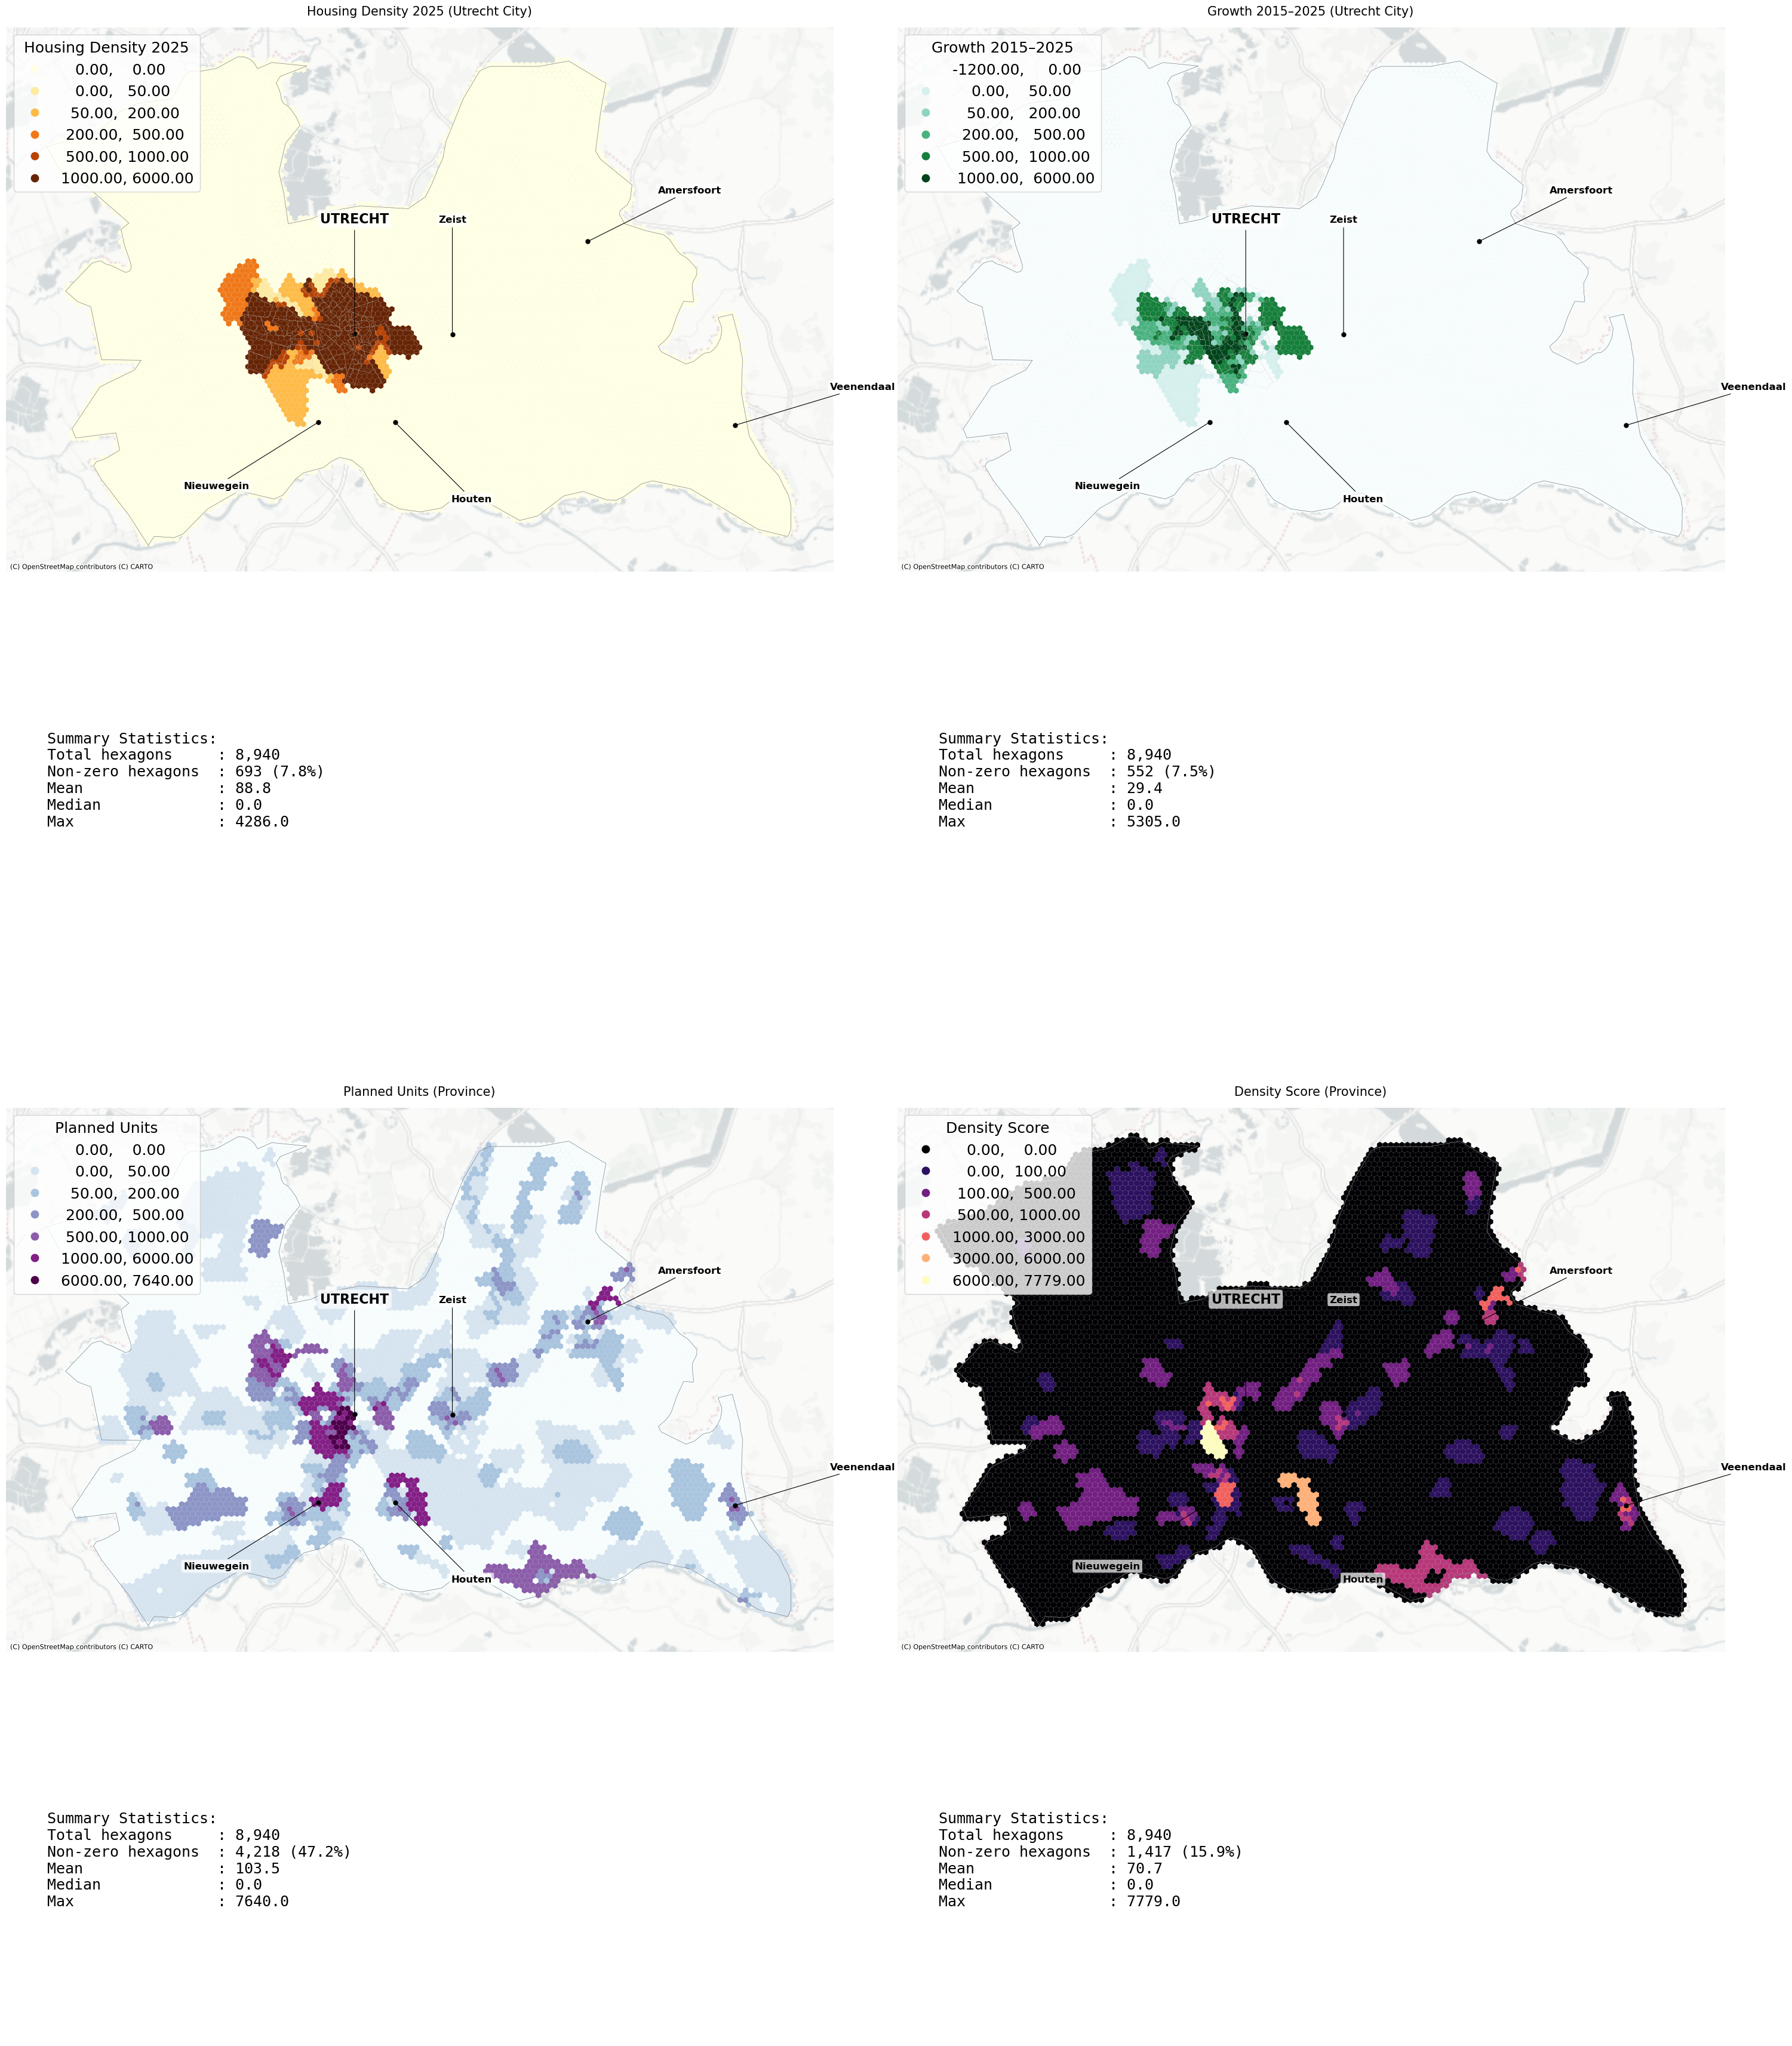

In [18]:
# === Plot merged housing layer (points + polygons) ===
plot = False  # Set to True to enable plotting, False to disable

custom_bins = {
    "housing_density_utrecht_2025": [0, 50, 200, 500, 1000, 6000],
    "absolute_growth_utrecht_2025": [0, 50, 200, 500, 1000, 6000],
    "planned_housing_units": [0, 50, 200, 500, 1000, 6000],
    "planned_density_score": [0, 100, 500, 1000, 3000, 6000]
}

# Define a dict to specify 70% transparency for hexes with value 0 for each column
zero_alpha_dict = {
    "housing_density_utrecht_2025": 0.3,
    "absolute_growth_utrecht_2025": 0.3,
    "planned_housing_units": 0.3,
    "planned_density_score": 0.3
}

plot_distribution_with_stats(
    gdf=hex_housing,  # your merged GDF
    columns=[
        "housing_density_utrecht_2025",
        "absolute_growth_utrecht_2025",
        "planned_housing_units",
        "planned_density_score"
    ],
    color_schemes={
        "housing_density_utrecht_2025": "YlOrBr",
        "absolute_growth_utrecht_2025": "BuGn",
        "planned_housing_units": "BuPu",
        "planned_density_score": "magma"
    },
    legend_titles={
        "housing_density_utrecht_2025": "Housing Density 2025",
        "absolute_growth_utrecht_2025": "Growth 2015–2025",
        "planned_housing_units": "Planned Units",
        "planned_density_score": "Density Score"
    },
    city_layers=[
        "housing_density_utrecht_2025",
        "absolute_growth_utrecht_2025"
    ],
    utrecht_outline=utrecht_province,  
    save_path=OUTPUT_DIR / "housing_features_points_polygons.png",
    use_log_scale=False,
    custom_bins=custom_bins,
 
)


In [19]:

## individual plots
PLOT_INDIVIDUAL_MAPS = False  # Set to True to enable plotting

if PLOT_INDIVIDUAL_MAPS:
    # Create housing_maps directory if it doesn't exist
    housing_maps_dir = OUTPUT_DIR / "housing_maps"
    housing_maps_dir.mkdir(exist_ok=True)

    # Export individual maps
    for col in ["housing_density_utrecht_2025", "absolute_growth_utrecht_2025", "planned_housing_units", "planned_density_score"]:
        # Plot and save map
        plot_distribution_with_stats(
            gdf=hex_housing,
            columns=[col],
            color_schemes={
                col: {
                    "housing_density_utrecht_2025": "YlOrBr",
                    "absolute_growth_utrecht_2025": "BuGn",
                    "planned_housing_units": "BuPu", 
                    "planned_density_score": "magma"
                }[col]
            },
            legend_titles={
                col: {
                    "housing_density_utrecht_2025": "Housing Density 2025",
                    "absolute_growth_utrecht_2025": "Growth 2015–2025",
                    "planned_housing_units": "Planned Units",
                    "planned_density_score": "Density Score"
                }[col]
            },
            city_layers=[col] if col in ["housing_density_utrecht_2025", "absolute_growth_utrecht_2025"] else [],
            utrecht_outline=utrecht_province,
            save_path=housing_maps_dir / f"{col}.png",
            use_log_scale=False,
            custom_bins={col: custom_bins[col]}
        )
        print(f"✅ Exported map for {col}")


## 3.0 Create Main DataFrame called hex_all_features 
##### begin combining jobs and housing DataFrames

In [20]:
# 1. Make sure both DataFrames have hex_id
for df in [hex_jobs, hex_housing]:
    if "hex_id" not in df.columns:
        df["centroid"] = df.geometry.centroid
        df["x"] = df["centroid"].x.astype(int)
        df["y"] = df["centroid"].y.astype(int)
        df["hex_id"] = df["x"].astype(str) + "_" + df["y"].astype(str)

# 2. Drop unnecessary geometry from one of them to avoid conflict
hex_housing_clean = hex_housing.drop(columns=["geometry"])

# 3. Merge on hex_id
hex_all_features = hex_jobs.merge(hex_housing_clean, on="hex_id", how="outer")

# 4. Drop centroids and x/y duplicates if needed
hex_all_features = hex_all_features.drop(columns=["centroid", "x", "y"], errors="ignore")
# 5. Confirm shape and preview
print(f"✅ Merged hex_all_features shape: {hex_all_features.shape}")
print(hex_all_features.head())
# Check for empty rows in hex_jobs and hex_housing dataframes
print("\nChecking for empty/null values in hex_jobs:")
print(hex_jobs.isnull().sum())

print("\nChecking for empty/null values in hex_housing:")
print(hex_housing.isnull().sum())

print("\nChecking for empty/null values in merged hex_all_features:")
print(hex_all_features.isnull().sum())

# Get total number of empty rows (all columns null)
empty_jobs = hex_jobs.isnull().all(axis=1).sum()
empty_housing = hex_housing.isnull().all(axis=1).sum()
empty_merged = hex_all_features.isnull().all(axis=1).sum()

print(f"\nCompletely empty rows:")
print(f"hex_jobs: {empty_jobs}")
print(f"hex_housing: {empty_housing}") 
print(f"hex_all_features: {empty_merged}")



✅ Merged hex_all_features shape: (8940, 14)
      x_x     y_x         hex_id  \
0  112644  470183  112644_470183   
1  112861  469808  112861_469808   
2  112861  470558  112861_470558   
3  113077  469433  113077_469433   
4  113077  470183  113077_470183   

                                            geometry  job_onsite  job_hybrid  \
0  POLYGON ((112861.409 470308.69, 112644.902 470...           0           0   
1  POLYGON ((113077.915 469933.69, 112861.409 470...           0           0   
2  POLYGON ((113077.915 470683.69, 112861.409 470...           0           0   
3  POLYGON ((113294.421 469558.69, 113077.915 469...           0           0   
4  POLYGON ((113294.421 470308.69, 113077.915 470...           0           0   

   job_uncertain  job_weighted     x_y     y_y  housing_density_utrecht_2025  \
0              0             0  112644  470183                           0.0   
1              0             0  112861  469808                           0.0   
2              0  

## 4.0 Export GeoDataFrame

In [21]:
# 1. Optional: Keep a backup before cleaning
hex_all_features_raw = hex_all_features.copy()

# 1. Drop all but one geometry column
# Keep the jobs geometry (usually geometry_x or geometry)
geom_col_to_keep = "geometry"  # or "geometry_x" if that’s the one with real hexes

# Drop other geometries
geometry_cols = [col for col in hex_all_features.columns if "geometry" in col and col != geom_col_to_keep]
hex_all_features = hex_all_features.drop(columns=geometry_cols, errors='ignore')

# 2. Ensure GeoDataFrame knows which geometry to use
hex_all_features = gpd.GeoDataFrame(hex_all_features, geometry=geom_col_to_keep, crs=28992)

# 3. Drop duplicate centroids/x/y helpers (optional cleanup)
hex_all_features = hex_all_features.drop(columns=[
    'centroid_x', 'centroid_y', 'x_x', 'y_x', 'x_y', 'y_y',
    'centroid', 'x', 'y'
], errors='ignore')

# 4. Save to file
output_path = QGIS_DIR / "hex_all_features_part1.gpkg"
hex_all_features.to_file(output_path, driver="GPKG")
print("✅ Saved cleaned GeoDataFrame.")



✅ Saved cleaned GeoDataFrame.
